In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
#! check if file names don't end in z0 (did some manual tests)
pix_dens_PF_halos = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF_halos = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF_halos.shape)
print(tot_dens_PF_halos.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
#! check if file names don't end in z0 (did some manual tests)
pix_dens_PF_seeds = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs_seeds_z0.npy")
tot_dens_PF_seeds = jnp.load(f"{sim_folder}/total_densities_incl_PFs_seeds_z0.npy")
print(pix_dens_PF_seeds.shape)
print(tot_dens_PF_seeds.shape)

# Deltas_halos = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# print(Deltas_halos.shape)

# Deltas_seeds = jnp.load(f"{sim_folder}/Deltas_seeds.npy")
# print(Deltas_seeds.shape)

(1, 5, 768)
(1, 50)
(1, 5, 768)
(1, 5)
(10, 5, 768)
(10, 5)


## Monopole perturbation

In [ ]:
colors = [
    "mediumblue", 
    "orangered"
]
labels = [
    "Fermi-Dirac", 
    "Primordial Fluctuations"
]

fig_paths = [
    f"{fig_folder}/overdensity_band_{sim_name}_linear.pdf",
    f"{fig_folder}/overdensity_band_{sim_name}_linear.png"
]

eta = 5*1e-1
SimPlot.overdensity_band(
    dens_FD=tot_dens_FD,
    dens_PF=tot_dens_PF_halos,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    colors=colors,
    labels=labels,
    plot_xlims=None,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_paths=fig_paths,
    args=Params())

## Dipole Perturbation

In [6]:
v_unit = (Params.kpc/Params.s)/(Params.km/Params.s)
vels = jnp.load(f"{sim_folder}/vectors_halo1.npy")[..., 0, 3:6]#*v_unit
v_mags = jnp.linalg.norm(vels, axis=-1)
print(vels.shape)

# Compute phase-space weights
p_arr, _ = Physics.velocities_to_momenta(vels, nu_m_picks, Params())
# print(p_arr.shape)

FD_arr = Physics.Fermi_Dirac(p_arr, Params())
# print(FD_arr.shape)

y = (v_mags[None,...]*v_unit)**3 * FD_arr  # dlog integrand
x = v_mags[None,...]*v_unit
v_raw = trap(y, jnp.log(x), axis=-1)

v_pre = simdata.pix_sr * Params.g_nu/((2*Params.Pi)**3)
v_avg = v_pre * v_raw
print(v_avg.shape)

mi = 0
print(v_avg[mi].min())
print(v_avg[mi].max())

# monopole = 

(768, 1000, 3)
(5, 768)
15256774.36891405
15256774.368914055


In [ ]:
colors = [
    "black", 
    "red"
]
labels = [
    "PF", 
    "MW + PF"
]

halo_limit = 2
SimPlot.bulk_velocity_band(
    sim_dir=sim_folder, 
    halo_num=1, 
    m_arr=nu_m_picks, 
    Deltas=jnp.load(f"{sim_folder}/Deltas_halos.npy")[:halo_limit,...], 
    colors=colors, 
    labels=labels, 
    plot_xlims=None, 
    plot_ylims=None, 
    # plot_ylims=(0,100), 
    fig_dir=fig_folder, 
    args=Params())

## CNB anisotropy x DM line-of-sight skymaps

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

fig_paths = [
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.png",
]

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_paths=fig_paths,
    args=Params())

## Phase-space distributions today

In [ ]:
def halo_parameters():
    ...
def escape_momentum():
    ...


SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=1, 
    fig_dir=fig_folder,
    args=Params())

## Temperature fluctuation skymaps from Cl

In [ ]:
SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.1, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

In [ ]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

## Comparison of FD & PF skymaps

### For 1 halo with seed 5 (as in T&Z paper)

In [ ]:
# Choose a halo and mass to display
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_halos[halo_i, mPF_i, :] / skymap_norm - 1
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 0.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm - 1
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 0.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

fig_paths = [
    f"{fig_folder}/FD_vs_PF_skymaps.pdf",
    f"{fig_folder}/FD_vs_PF_skymaps.png"
]

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_paths=fig_paths,
    args=Params)

### For 1 halo and a different seed (for sanity check)

In [ ]:
# Choose a halo and mass to display
seed_i = 0
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_seeds[seed_i, mPF_i, :] / skymap_norm
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

fig_paths = [
    f"{fig_folder}/FD_vs_PF_skymaps_seed{seed_i}.pdf",
    f"{fig_folder}/FD_vs_PF_skymaps_seed{seed_i}.png"
]

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_paths=fig_paths,
    args=Params)

## Comparison of FD & PF power spectra

### Uniform skymap -> zig-zag behaviour?

Yes, when the skymap has uniform non-zero values. However, if the monopole is removed (the healpy doc of anafast actually recommends this to reduce "boundary effects") then the power spectrum flattens out at higher l.

In [ ]:
uniform_skymap = np.zeros(simdata.Npix)
cl_uni = hp.sphtfunc.anafast(uniform_skymap, lmax=None)
ell = jnp.arange(len(cl_uni))
power_spectrum_uni = ell * (ell+1) * cl_uni * Primordial.Cl_scaling / (2*Params.Pi)
print(power_spectrum_uni[:21])

fig = plt.figure(figsize =(6, 4))
fig.tight_layout()
ax1 = fig.add_subplot(111)

FD_color = "mediumblue"
ax1.semilogy(
    ell, power_spectrum_uni, color=FD_color, 
    label='Fermi-Dirac')
ax1.set_title(fr"Power spectra comparison $m_\nu = ${m_pick} eV")
ax1.set_xlabel("$\ell$")
ax1.set_xlim(1,np.max(ell))
ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell} \, / \, 2\pi \,\, [\mu K^2]$")
# ax1.set_ylim(1e-1, 1e7)
ax1.grid(True, which="major", linestyle="dashed")
ax1.legend(loc='upper right', prop={'size':8})
plt.show(); plt.close()

### 10 Halos - 1 PF

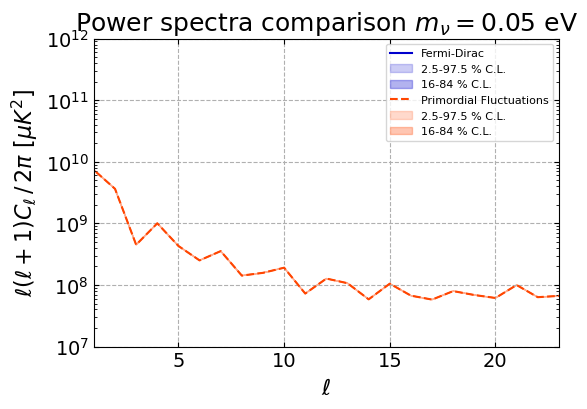

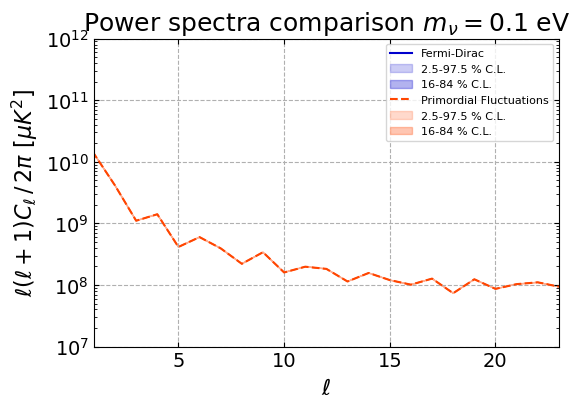

In [7]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in nu_m_picks[1:3]:
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD - skymap_norm,
        pix_dens_PF=pix_dens_PF_halos - skymap_norm,
        y_lims=(1e7, 1e12),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

### 1 Halo - 10 PFs

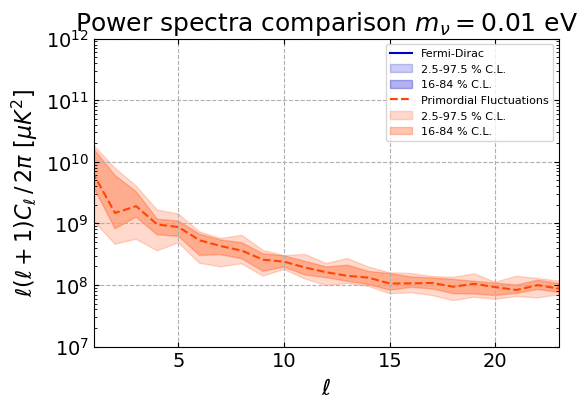

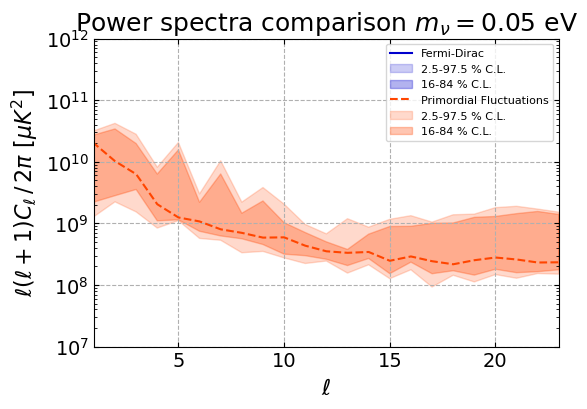

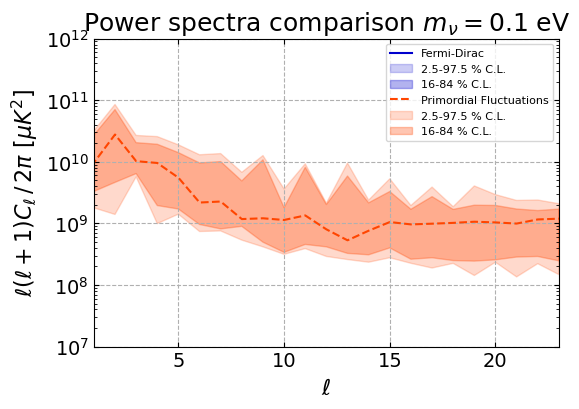

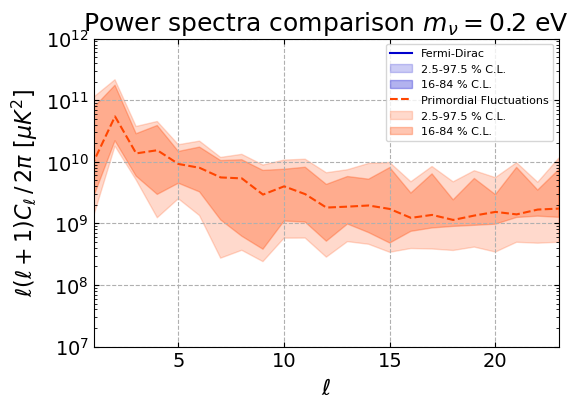

In [4]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
pix_dens_FD_1Halo = jnp.repeat(pix_dens_FD[0][None,...], 10, axis=0)

for m_pick in nu_m_picks[0:4]:
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD_1Halo - skymap_norm,
        pix_dens_PF=pix_dens_PF_seeds - skymap_norm,
        y_lims=(1e7, 1e12),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params,
        _1Halo=True)